# Example 2 -- Transition Magnetic Moments

In this notebook, we explore the case of a transition magnetic moment, making use of the single photon
$$ N \to \nu \gamma $$
as well as dilepton,
$$ N \to \nu \ell^+\ell^- $$
decays of the heavy neutrinos.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import DarkNews as dn
from DarkNews import *

In [3]:
from DarkNews import GenLauncher

model_kwargs = {
    'm4': 0.140,
    'mu_tr_mu4': 1e-6, # GeV^-1
    'UD4': 0,
    'Umu4': 0,
    'epsilon': 0.0,
    'gD': 0.0,
}

# turning off Helicity conserving scattering which is negligible for TMM (but dominant for Z', for instance).
# we also ask for the single photon decays.
gen_object = GenLauncher(decay_product='photon', noHC=True, HNLtype="dirac", **model_kwargs)
df_photon = gen_object.run()

gen_object = GenLauncher(decay_product='e+e-', noHC=True, HNLtype="dirac", **model_kwargs)
df_ee = gen_object.run()

---------------------------------------------------------
   ______           _        _   _                     
   |  _  \         | |      | \ | |                    
   | | | |__ _ _ __| | __   |  \| | _____      _____   
   | | | / _  | ___| |/ /   | .   |/ _ \ \ /\ / / __|  
   | |/ / (_| | |  |   <    | |\  |  __/\ V  V /\__ \  
   |___/ \__,_|_|  |_|\_\   \_| \_/\___| \_/\_/ |___/  

---------------------------------------------------------
Model:
	1 dirac heavy neutrino(s).

---------------------------------------------------------
Experiment:
	MiniBooNE_FHC
	fluxfile loaded: MiniBooNE_FHC.dat
	POT: 1.875e+21
	nuclear targets: ['C12', 'H1']
	fiducial mass: [701.1428571428571, 116.85714285714286] tonnes

---------------------------------------------------------
Generating Events using the neutrino-nucleus upscattering engine

nu(mu) C12 --> N4  C12 --> nu_light gamma C12
Helicity flipping upscattering.
N4 decays via TMM.
Parent N4 proper decay length: 1.807E+02 cm.

Predicted (

Let's look at the columns in the single photon case. We lose the ell_minus and ell_plus columns and gain the photon one.

In [4]:
df_photon.columns.levels[0]

Index(['P_decay_N_daughter', 'P_decay_N_parent', 'P_decay_photon',
       'P_projectile', 'P_recoil', 'P_target', 'pos_scatt', 'w_decay_rate_0',
       'w_event_rate', 'w_flux_avg_xsec', 'target', 'target_pdgid',
       'scattering_regime', 'helicity', 'underlying_process', 'h_projectile',
       'h_parent', 'pos_decay'],
      dtype='object')

Text(0.5, 0, '$\\theta_{\\gamma}$ (degrees)')

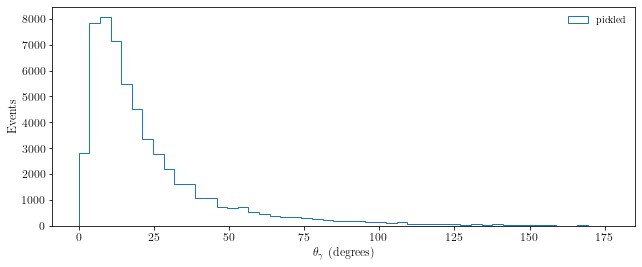

In [5]:
mee = np.arccos(dn.fourvec.df_cos_azimuthal(df_photon['P_decay_photon']))*dn.const.rad_to_deg

fig, ax = dn.plot_tools.std_fig(figsize=(10,4))

_=ax.hist(mee, weights=df_photon['w_event_rate',''], bins=50, histtype='step', label='pickled')

ax.legend(loc='best')
ax.set_ylabel('Events')
ax.set_xlabel(r'$\theta_{\gamma}$ (degrees)')

Text(0.5, 0, '$\\cos{\\theta_{\\gamma}}$')

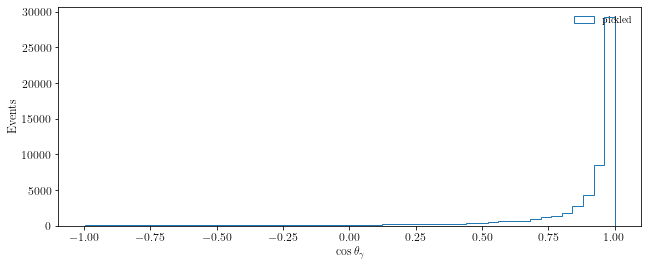

In [6]:
mee = dn.fourvec.df_cos_azimuthal(df_photon['P_decay_photon'])

fig, ax = dn.plot_tools.std_fig(figsize=(10,4))

_=ax.hist(mee, weights=df_photon['w_event_rate',''], bins=50, histtype='step', label='pickled')

ax.legend(loc='best')
ax.set_ylabel('Events')
ax.set_xlabel(r'$\cos{\theta_{\gamma}}$')

Text(0.5, 0, '$E_{\\gamma}$ (GeV)')

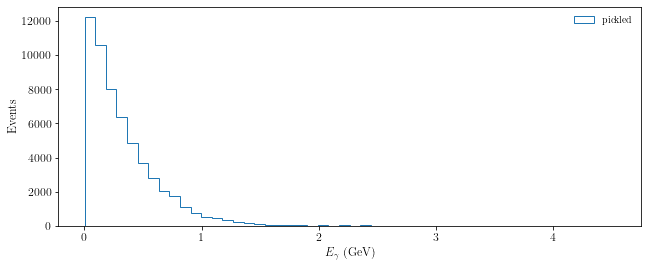

In [7]:
egamma = df_photon['P_decay_photon','0']

fig, ax = dn.plot_tools.std_fig(figsize=(10,4))

_=ax.hist(egamma, weights=df_photon['w_event_rate',''], bins=50, histtype='step', label='pickled')

ax.legend(loc='best')
ax.set_ylabel('Events')
ax.set_xlabel(r'$E_{\gamma}$ (GeV)')

#### Now we compute a couple of magnetic moment cases with Z boson contributions included

In [8]:
model_kwargs = { 'm4': 0.40, 'UD4': 0, 'epsilon': 0}

dfs_nomix=[]
dfs_mix=[]
mutrs = [1e-15, 2e-10, 3e-9,3e-8]
for mutr in mutrs:
    gen_object = GenLauncher(mu_tr_mu4=mutr, Umu4=1.5e-3, experiment = "microboone", decay_product='photon', neval = 10000, noHC=True, HNLtype="dirac", loglevel='ERROR', **model_kwargs)
    dfs_mix.append(gen_object.run())

    gen_object = GenLauncher(mu_tr_mu4=mutr, Umu4=0.0, experiment = "microboone", decay_product='photon', neval = 10000, noHC=True, HNLtype="dirac", loglevel='ERROR', **model_kwargs)
    dfs_nomix.append(gen_object.run())


Initializing the three-portal model.


/home/dmass/Documents/GitHub/DarkNews-generator/src/DarkNews/MC.py:224: UserWarning: gammaQ convergence not complete -- want: nan << 1e-05
  logger.debug(f"Vegas results for the integrals: {result.summary()}")


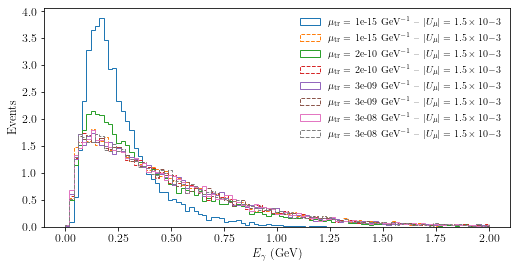

In [9]:
fig, ax = dn.plot_tools.std_fig(figsize=(8,4))

for df_mix,df_nomix,mutr in zip(dfs_mix,dfs_nomix,mutrs):
    egamma = df_mix['P_decay_photon','0']
    _=ax.hist(egamma, weights=df_mix['w_event_rate',''], bins=np.linspace(0,2,100), histtype='step', density=True, label=fr'$\mu_{{\rm tr}} = $ {mutr} GeV$^{{-1}}$ -- $|U_{{\mu}}|=1.5\times10{{-3}}$')

    egamma = df_nomix['P_decay_photon','0']
    _=ax.hist(egamma, weights=df_nomix['w_event_rate',''], bins=np.linspace(0,2,100), histtype='step', ls='--', density=True, label=fr'$\mu_{{\rm tr}} = $ {mutr} GeV$^{{-1}}$ -- $|U_{{\mu}}|=1.5\times10{{-3}}$')

ax.legend(loc='best')
ax.set_ylabel('Events')
ax.set_xlabel(r'$E_{\gamma}$ (GeV)')
dn.plot_tools.std_savefig(fig,'plots/TMM_and_mixing.pdf')